In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#mpl.rcParams["savefig.dpi"]=140
#mpl.rcParams["figure.dpi" ]=140

## Coloring based on nearest hybercube

Define a planar cut through an ND lattice, and color pixels on this plane according to nearest cube.

Note: To simplify some things later:
- Ensure that all angles are positive
- Ensure that the last angle is π (vertical)

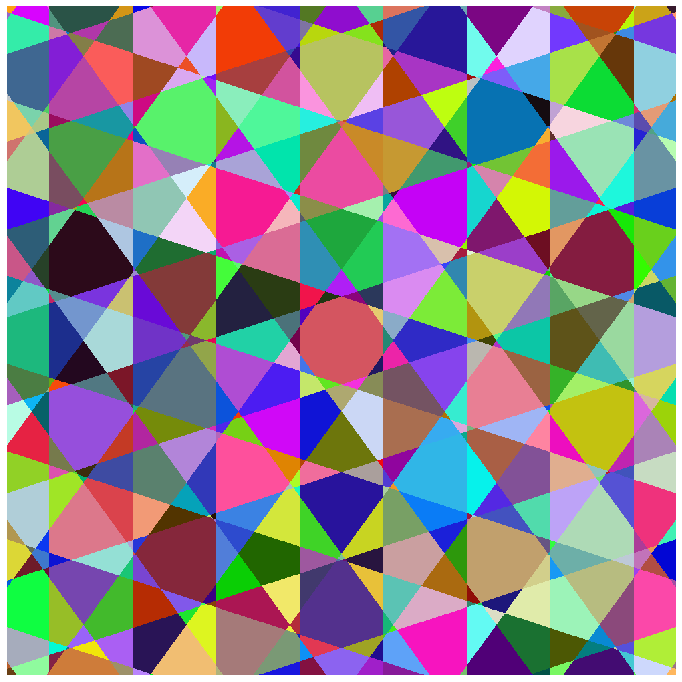

In [15]:
from scipy.spatial.distance import squareform, pdist
from pylab import *
from numpy import * 

N = 5                      # Dimension of crystal
θ = linspace(0,pi,N+1)[1:] # Arrange basis vectors evenly on [0,π)
A = array([cos(θ),sin(θ)]) # Convert from complex notation

L  = 1001  # Number of grid points to search over
dx = 4    # Size of square portion of plane to check

# Generate the search grid
x  = linspace(-dx,dx,L)
xy = array(meshgrid(x,x)).reshape(2,L*L)

# Collapse all grid points to the nearest hyper-cell 
p  = np.round(A.T@xy)

# Refer to each intersected hypercel by the projection of
# its center on the plane. Encode these pts as complex numbers
u  = [1,1j]@pinv(A).T@p
q  = unique(u)

# Assign random colors to each intersected hyper-cell 
colors = {qi:random.rand(3) for qi in q}

# Color the grid
figure(figsize=(10,10))
imshow(array([colors[ui] for ui in u]).reshape(L,L,3),interpolation="nearest")
tight_layout(); axis("off")
savefig("qq0_cl_n%d.png"%N)

# Xor of (square) plane waves

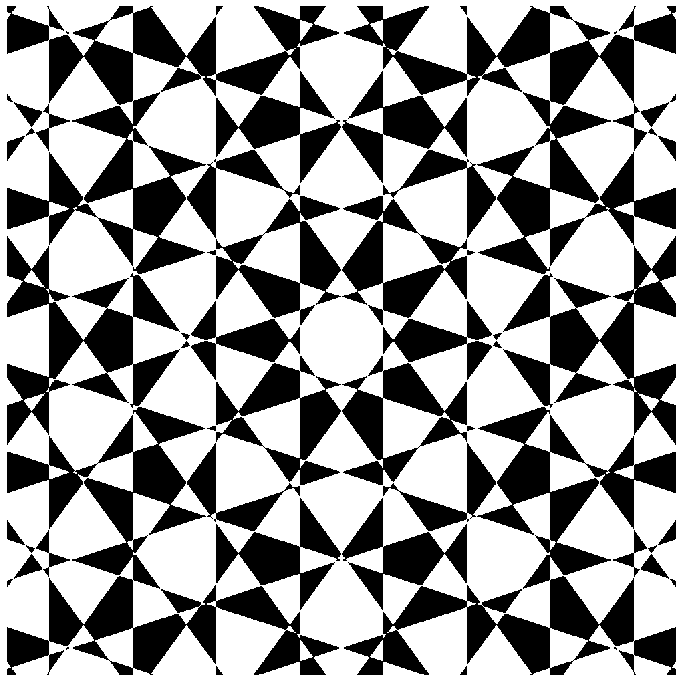

In [16]:
wavesum = sum(sign(cos((A.T@xy)*pi)),0)
figure(figsize=(10,10))
imshow((wavesum/2%2).reshape(L,L),interpolation="nearest",cmap='Greys')
tight_layout(); axis("off")
savefig("qq0_bw_n%d.png"%N)

## Rhombic tiling: Brute-force approach

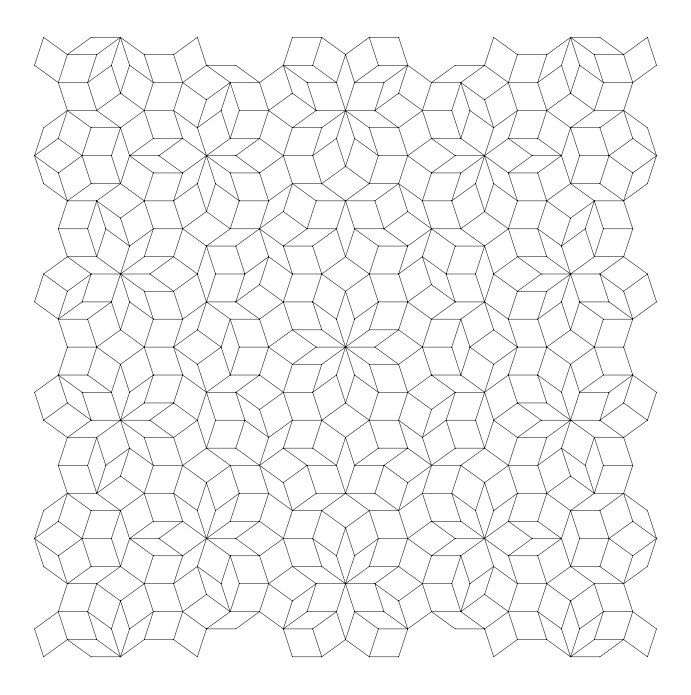

In [17]:
# Collapse all grid points to the nearest hyper-cell 
p  = unique(np.round(A.T@xy),axis=1)

def plotpoints(p):
    u  = pinv(A).T@p
    D  = squareform(pdist(p.T))
    e  = {tuple(sorted(e)) for e in zip(*where(abs(D-1)<1e-6))}
    xy = concatenate([[u[:,a],u[:,b],[NaN,NaN]] for a,b in e])
    plot(*xy.T,lw=0.5,color='k')
    tight_layout()
    axis("equal")
    axis("off")
    
figure(figsize=(10,10))
plotpoints(p)
savefig("qq1_n%d.png"%N)

## Better way

- Waves cut up plane into strips
- Each strip is identified by an integer
- Integers for all strips are indecies for a cell in the (hyper)lattice
- If a set of N strips intersects in the plane, then the plane intersects the corresponding hypercell
- The intersection of N strips can be computed as the intersection of 2N half-planes
- We can test this using linear programming, or the Preparata and Muller algorithm

## Strip intersection, linear programming variant

- Recursively search for cells intersecting the plane, starting from an initial "seed"
- Use linear programming to check whether plane intersects each cell
- Restrict search space and cache results to reduce computatoinal cost
  - For a $N$-d quasicrystal, we get $2N$-fold symmetry about the origin. There is also a reflection symmetry. 
- Convert lattice indicies into 2N half-plane intersections
 - I think this amounts to projecting they hyperlattice point onto the cutting plane, and then 

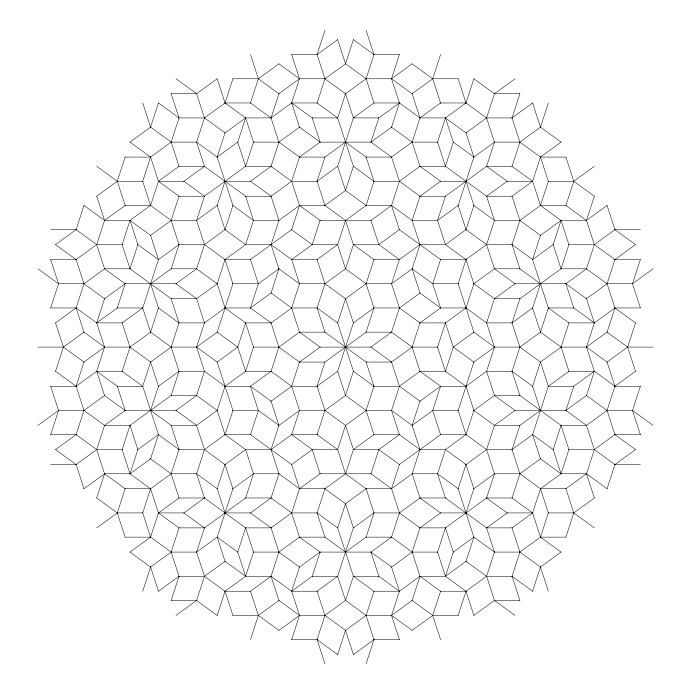

In [18]:
from scipy.optimize import linprog

# Number of search iterations
Ndepth = 15

# Directions in which to search
D = int32(concatenate([eye(N),-eye(N)])) 

# Matrix to rotate a lattice point π/N in 2D plane
S = zeros((N,N))
S[ -1,0 ] = -1
S[:-1,1:] = eye(N-1)

# Generic caching intersection check function
# Map all points to first quadrant and memoize
def cached_crystal_checker(check):
    # Cache results to save time (memoization)
    cache = {}
    def f(q):
        # Convert test point to immutable tuple for cache key
        k = tuple(int32(q)) 
        if not k in cache:
            # Recompute intersection test if not in cache
            # Use symmetry: reduce tests to points in 1st sector
            h = angle([1,1j]@A@q)
            cache[k]=check(q) if 0<=h<=(pi/N*1.1) else f(S@q)
        return cache[k]
    f.__cache__ = cache
    return f

# Check if intersection of half-planes is nonempty using linear programming
# Check feasibility of set of constraints phrased as
# Left-Hand Side (LHS) is ≤ Right Hand Side (RHS)
# A_ub parameter is the LHS of inequality as a matrix (the linear equations)
# b_ub parameter is the RHS of inequality as a vector (the bounds)
# c is the objective to optimize; only care about feasability so can be anything≠(0,0)
# Matrix encoding LHS of linear inequalities for LP
Aub = concatenate([ A.T,-A.T])
# Use linear programming to see if plane
# intersects hypercube ±0.5 of p
@cached_crystal_checker
def check_lp(q):
    return linprog(c=[1,1],A_ub=Aub,
        b_ub=concatenate([.5+q,.5-q]),
        method="revised simplex",
        options={"tol":1e-9}).success
    
# Start with a seed point at zero and build outwards
# Iteratively search in each direction to add points
Q,allQ = {(0,)*N},set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if check_lp(q)}-allQ
    allQ |= Q

figure(figsize=(10,10))
plotpoints(array(list(allQ)).T)
savefig("qq2_n%d.png"%N)

## Strap intersection using intersection of half planes $N \log(N)$

- Create upper/lower feasibility region
- Ternary search to check if nonempty


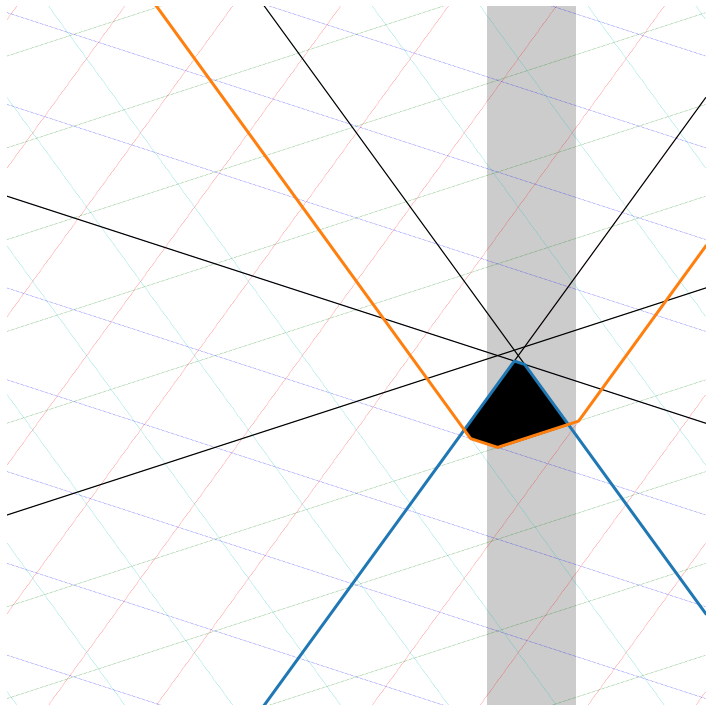

In [20]:
# Choose an example test point
allQ = [*allQ]
p = array(allQ[np.random.randint(0,len(allQ))])

# Get slopes and spacing of boundary lines
m = 1/tan(θ[:-1])
d = 1/sin(θ[:-1])

# Upper and lower feasibility curves
yu = np.min(outer(x,m)+(p[:-1]+0.5)*d,axis=1)
yl = np.max(outer(x,m)+(p[:-1]-0.5)*d,axis=1)

# Plot
figure(figsize=(10,10))
for i in range(N-1):
    for b in range(-10,10):
        plot(x,x*m[i]+(b+0.5)*d[i],color='rgbcmyk'[i],lw=0.5,linestyle=':')
for i,b in enumerate(p[:-1]):
    plot(x,x*m[i]+(b+0.5)*d[i],color='k',lw=1.2)
axvspan(p[-1]-0.5,p[-1]+0.5,color=(0.8,)*3,zorder=-100)
plot(x,yu,lw=3)
plot(x,yl,lw=3)
fill_between(x,yl,yu,zorder=-99,color='k',where = yu>yl)
axis('square'); axis('off'); tight_layout()
xlim(-dx,dx)
ylim(-dx,dx)

savefig("intersect_n%d.png"%N)

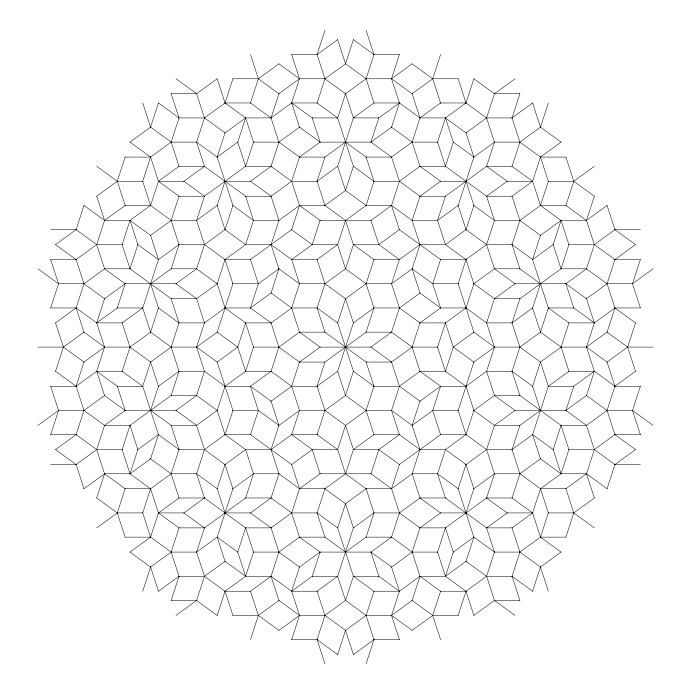

In [21]:
@cached_crystal_checker
def check_pm(p,eps=1e-3,maxiter=1000):
    p = int32(p)
    # Evaluate upper/lower bounds
    lp,up = p[:-1]-0.5, p[:-1]+0.5
    def feasibility_surface(p,x):
        u,l = x*m+up*d, x*m+lp*d
        y   = np.max(l)-np.min(u)
        dy  = m[np.argmax(l)]-m[np.argmin(u)]
        return y,dy
    # Initial bounds and feasability checks
    # If either bound satisfies, success
    # If better point not in bounds, fail
    x0,x1  = p[-1]-0.5, p[-1]+0.5
    y0,dy0 = feasibility_surface(p,x0)
    y1,dy1 = feasibility_surface(p,x1)
    if y0 < 0 or y1 < 0: return True
    if dy0>=0 or dy1<=0: return False
    for i in range(maxiter):
        # Guess min by following slope at bounds
        xm = (y1-y0-dy1*x1+dy0*x0)/(dy0-dy1)
        assert xm>=x0-eps
        assert xm<=x1+eps
        # Midpoint works? still feasible? 
        ym,dym = feasibility_surface(p,xm)
        if ym<0:   return True
        if dym==0: return False
        # Binary search: move inward if not done
        if dym<0:
            # If better point not in bounds, fail
            if dym>=0 or abs(x0-xm)<eps: return False
            x0,y0,dy0 = xm,ym,dym
        else:
            if dym<=0 or abs(x1-xm)<eps: return False
            x1,y1,dy1 = xm,ym,dym
    # Should have returned succes/fail before getting here
    raise RuntimeError("Maximum iterations exceeded: p=%s"%p)

# Start with a seed point at zero and build outwards
# Iteratively search in each direction to add points
Q,allQ = {(0,)*N},set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if check_pm(q)}-allQ
    allQ |= Q

figure(figsize=(10,10))
plotpoints(array(list(allQ)).T)
savefig("qq2_n%d.png"%N)

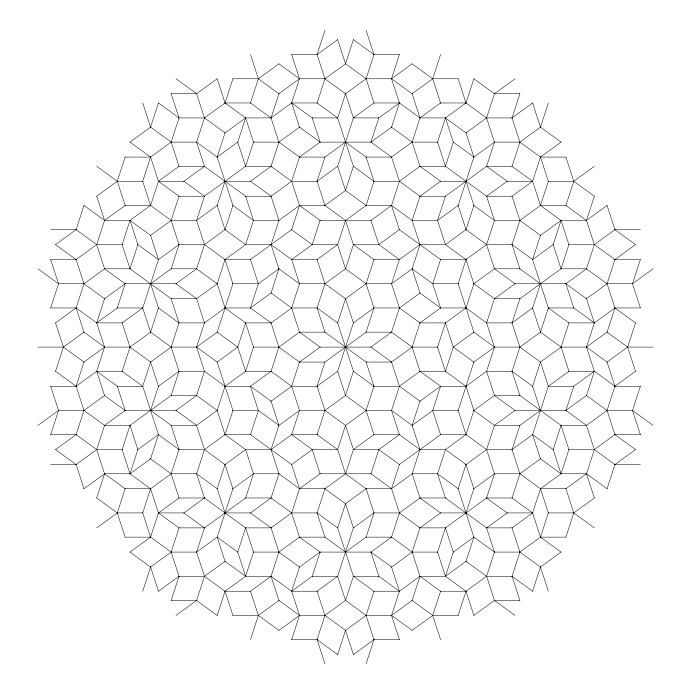

In [22]:
from scipy.linalg import null_space
from itertools import product, combinations

# Null space: collapses cutting plane to point at origin
C = null_space(A).T

# All vertices of an N-cube
O = array([*product(*([0,1],)*N)])-0.5

# All vertices of a 2-cube (used to generate N-2 sub-facets)
F = array([*product(*([0,1],)*2)])

# A single corner ("origin" vertex) of an N-2 cube
# plus N-2 vectors defining the other points on the N-2 cube
# Used to test if sub-facet contains the origins
i = [0]+[*2**arange(N-2)]
G = array([*product(*([0,1],)*(N-2))])[i,:]

# All possible pairs of dimension for generating
# all possible N-2 sub-facets of the N-cube
I = [*combinations(range(N),2)]

# Given a list of N-cube vertices, construct a list
# of all N-2-cube sub-facets.
subfacets = []
for ij in I:
    # For every pair of directions, and for every 2-cube
    # in each pair of directions... Generate all possible
    # N-2-cube sub-facets.
    v0 = F@eye(N)[ij,:]
    v1 = G@eye(N)[[*{*range(N)}-{*ij}]]
    subfacets.extend(v0[:,None,:]+v1[None,:,:])
vxid = int32(subfacets)@2**arange(N,dtype='i')

# Chec if a sub-facet contains the origin
def subfacet_contains(v):
    p0 = v[0]
    vk = v[1:,:]-p0
    q  = -np.linalg.solve(vk@vk.T,vk@p0)
    return all(q>=0) and all(q<=1)

# Check if N-2 projection of N-cube contains the origin
# (thereby checking for plane-cube intersection)
@cached_crystal_checker
def check_g2(q):
    # Generate list of all N-2 dimensional sub-facets
    # of unit N-cube centered at q
    p  = (q+O).T
    sf = (C@p)[:,vxid].transpose(1,2,0)
    for v in sf:
        if subfacet_contains(v): return True
    return False

Q,allQ = {(0,)*N},set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if check_g2(q)}-allQ
    allQ |= Q

figure(figsize=(10,10))
plotpoints(array(list(allQ)).T)
savefig("qq2_n%d.png"%N)